In [ ]:
!pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.9 MB/s eta 0:00:00


In [ ]:
import kagglehub
import os
import random
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence



In [ ]:
ixi_dataset_path = kagglehub.dataset_download("haonanzhou1/ixit2-slices")
brats_dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation") + "/BraTS2020_TrainingData"

In [ ]:
def display_images(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

def display_images_nii(directory):
    pairs = []
    for root, dirs, files in os.walk(directory):
        flair_files = [f for f in files if f.endswith("_flair.nii")]
        for flair_file in flair_files:
            seg_file = flair_file.replace("_flair", "_seg")
            seg_path = os.path.join(root, seg_file)
            t2_file = flair_file.replace("_flair", "_t2")
            t2_path = os.path.join(root, t2_file)
            flair_path = os.path.join(root, flair_file)
            if os.path.exists(seg_path) and os.path.exists(t2_path):
                pairs.append((flair_path, seg_path, t2_path))
    return pairs

ixi_images = display_images(ixi_dataset_path)
pairs = display_images_nii(brats_dataset_path)

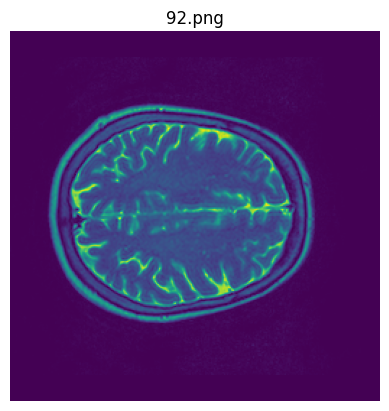

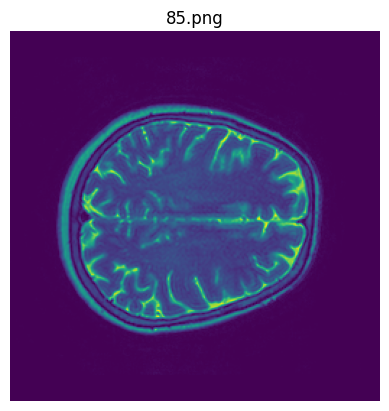

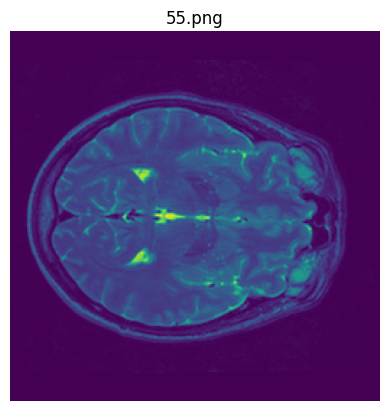

In [ ]:
selected_images = random.sample(ixi_images, 3)

for image_path in selected_images:
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title('/'.join(image_path.split('/')[-1:]))
    plt.axis('off')
    plt.show()

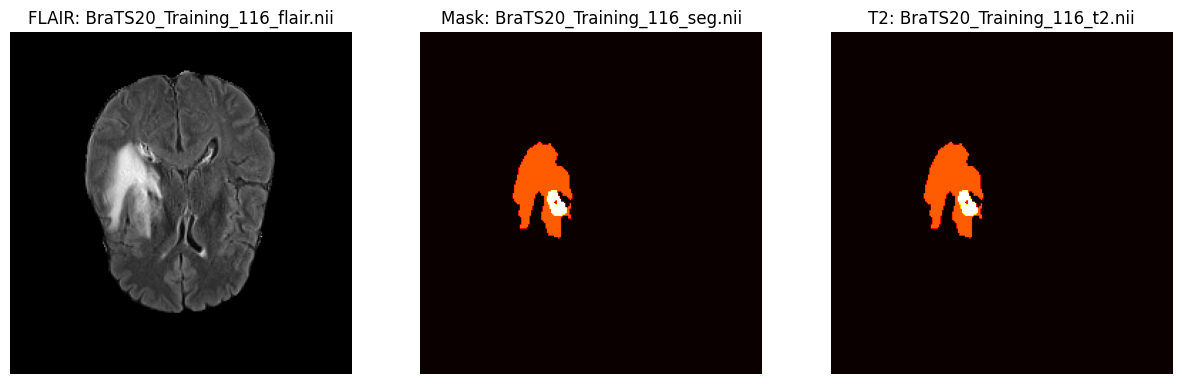

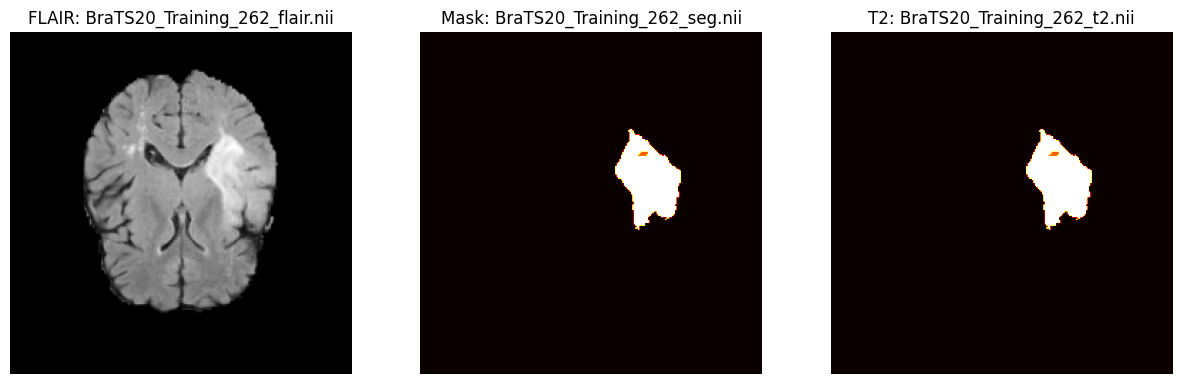

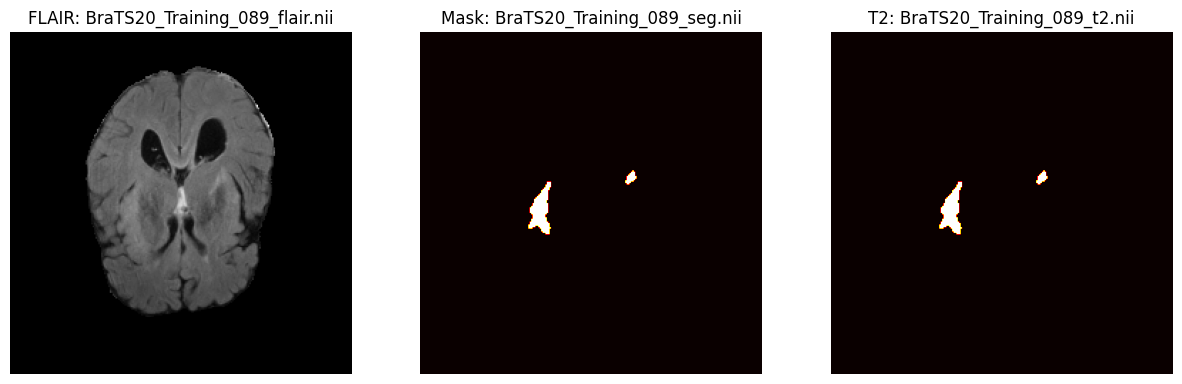

In [ ]:
selected_pairs = random.sample(pairs, 3)

for i, (flair_path, seg_path, t2_path) in enumerate(selected_pairs):
    flair_img = nib.load(flair_path).get_fdata()
    seg_img = nib.load(seg_path).get_fdata()
    t2_img = nib.load(t2_path).get_fdata()

    mid_slice = flair_img.shape[2] // 2
    flair_slice = flair_img[:, :, mid_slice]
    seg_slice = seg_img[:, :, mid_slice]
    t2_slice = t2_img[:, :, mid_slice]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"FLAIR: {os.path.basename(flair_path)}")
    plt.imshow(flair_slice.T, cmap="gray", origin="lower")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Mask: {os.path.basename(seg_path)}")
    plt.imshow(seg_slice.T, cmap="hot", origin="lower")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"T2: {os.path.basename(t2_path)}")
    plt.imshow(seg_slice.T, cmap="hot", origin="lower")
    plt.axis("off")

    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers

latent_dim = 1024
time.sleep(600)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_vae():
    # Encoder
    encoder_inputs = layers.Input(shape=(256, 256, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 64, activation='relu')(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoder_outputs, name='decoder')

    # VAE
    z_mean, z_log_var, z = encoder(encoder_inputs)
    vae_outputs = decoder(z)
    vae = Model(encoder_inputs, vae_outputs, name='vae')

    class VAELossLayer(layers.Layer):
        def call(self, inputs):
            encoder_inputs, vae_outputs, z_mean, z_log_var = inputs
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.MSE(encoder_inputs, vae_outputs), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            kl_loss = tf.reduce_mean(kl_loss)
            self.add_metric(total_loss, name='Loss')
            self.add_metric(reconstruction_loss, name='Reconstruction Loss')
            self.add_metric(kl_loss, name='KL Loss')
            self.add_loss(reconstruction_loss + kl_loss)
            return vae_outputs

    vae_outputs = VAELossLayer()([encoder_inputs, vae_outputs, z_mean, z_log_var])
    vae = Model(encoder_inputs, vae_outputs, name='vae')
    return vae

vae = create_vae()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [ ]:
history = vae.fit(ixi_images, epochs=20, batch_size=16)

Epoch 1/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - Loss: 3448.3831 - Reconstruction Loss: 2948.6508 - KL Loss: 499.7323
Epoch 2/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - Loss: 1649.9961 - Reconstruction Loss: 1364.1616 - KL Loss: 285.8346
Epoch 3/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - Loss: 1314.8488 - Reconstruction Loss: 1124.7082 - KL Loss: 190.1406
Epoch 4/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - Loss: 1086.5418 - Reconstruction Loss: 938.0700 - KL Loss: 148.4718
Epoch 5/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - Loss: 979.7722 - Reconstruction Loss: 824.9078 - KL Loss: 154.8644
Epoch 6/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - Loss: 873.5693 - Reconstruction Loss: 719.0712 - KL Loss: 154.4981
Epoch 7/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - Loss: 794.4569 - Reconstruction Loss: 641.1274 - KL Loss: 153.3295
Epoch 8/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - Loss: 734.8023 - Reconstruction Loss: 581.6797 - KL Loss: 153.1225
E

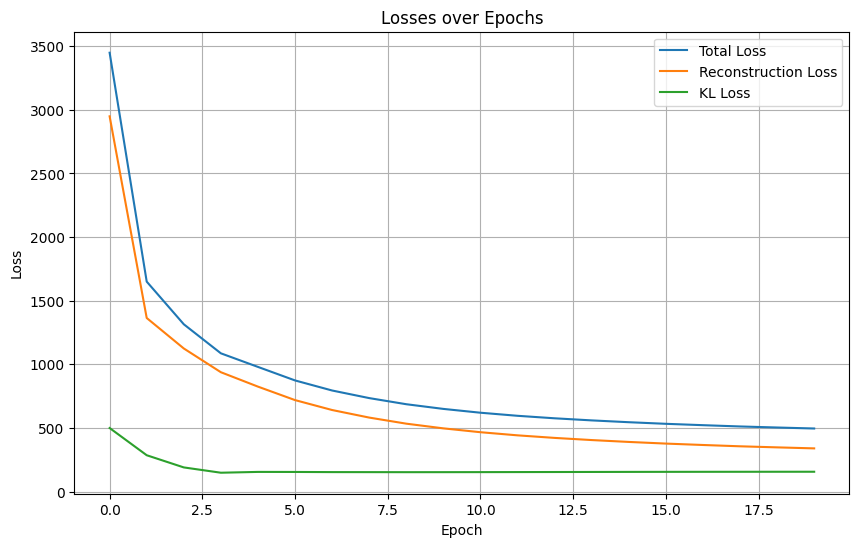

In [ ]:

plt.figure(figsize=(10, 6))

plt.plot(history['losses', label='Total Loss')
plt.plot(history['reconstruction_losses'], label='Reconstruction Loss')
plt.plot(['kl_losses'], label='KL Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

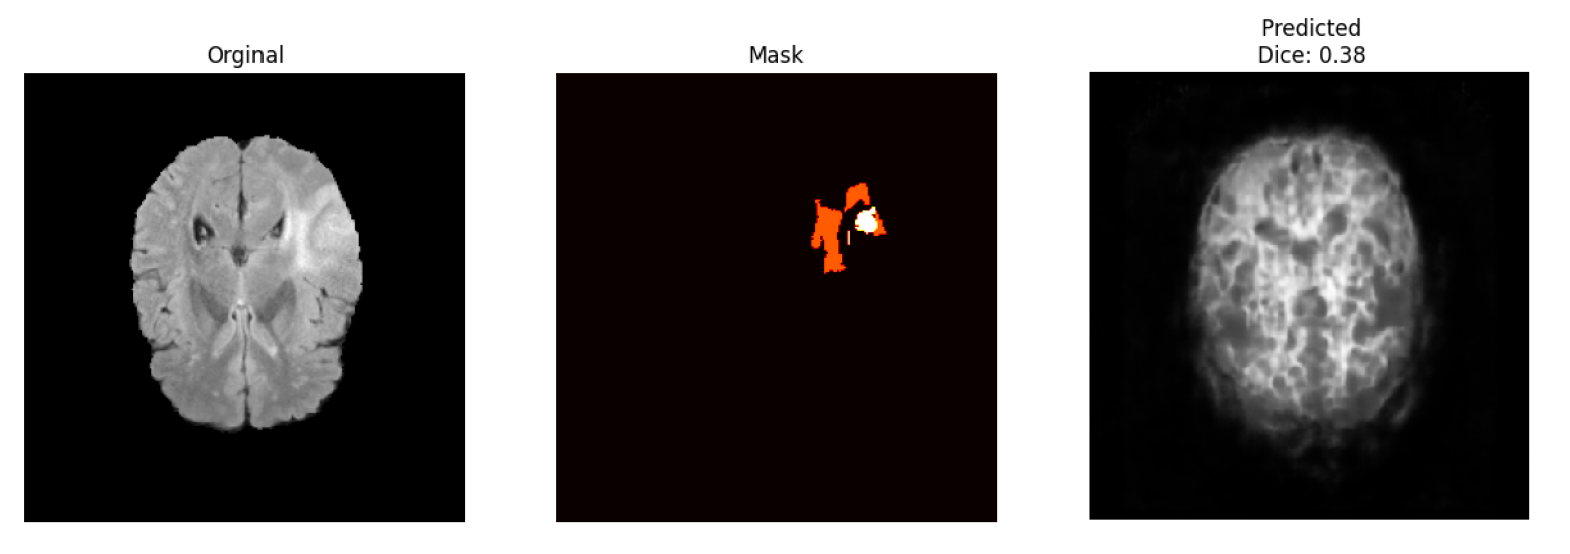

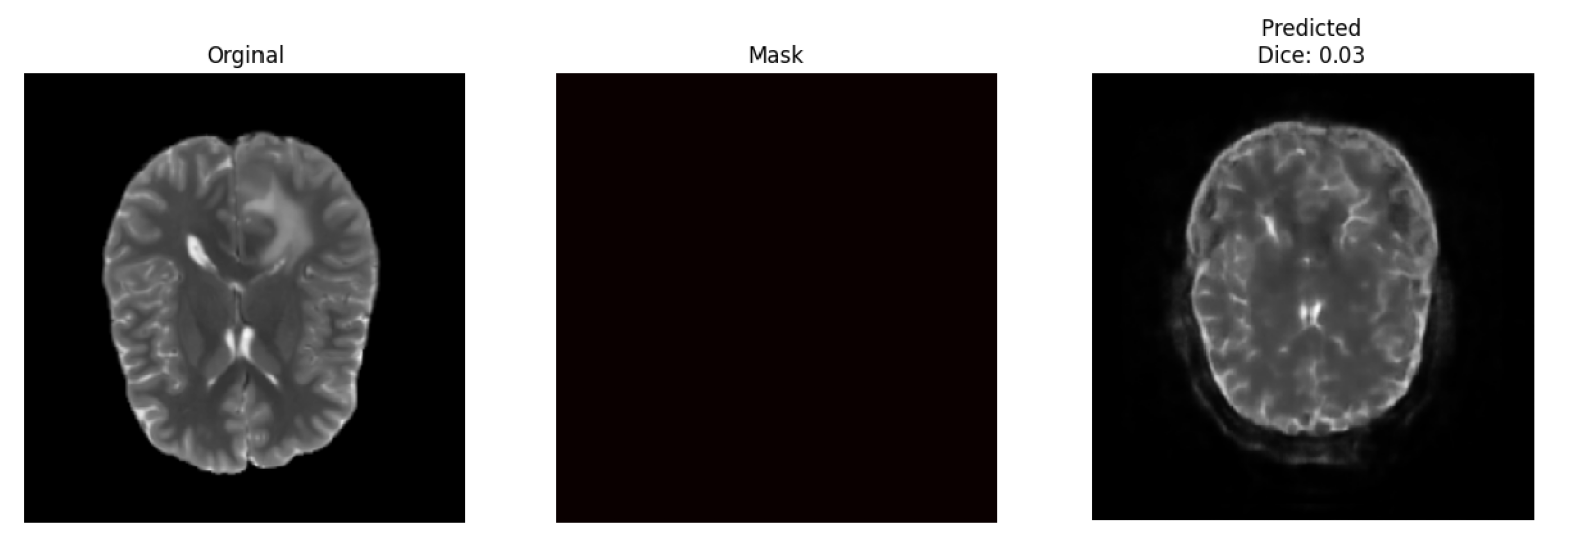

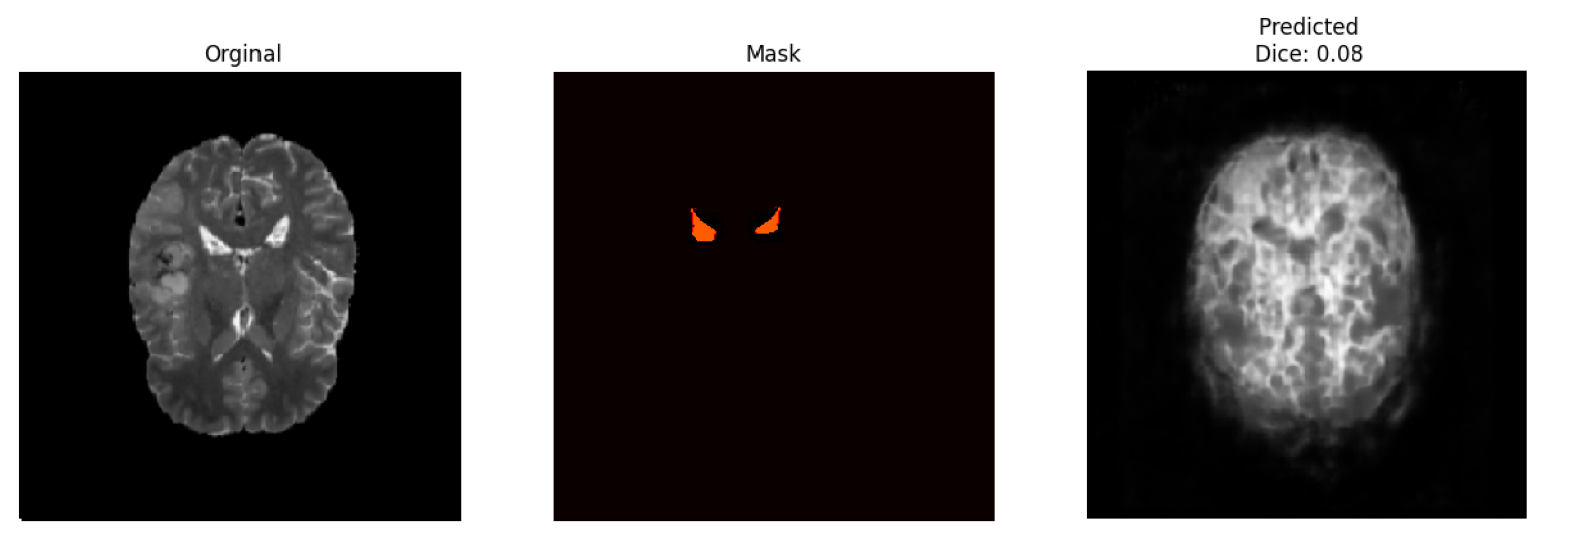

In [8]:
def get_tumorous_slices(images, masks, num_slices=3):
    tumorous_indices = [i for i in range(len(masks)) if np.any(masks[i] > 0)]
    selected_indices = np.random.choice(tumorous_indices, num_slices, replace=False)
    return images[selected_indices], masks[selected_indices]

num_slices = 3
sample_images, sample_masks = get_tumorous_slices(brats_images, brats_masks, num_slices)
predicted_masks = vae.predict(sample_images)
predicted_masks_binary = (predicted_masks > 0.5).astype(np.float32)

def calculate_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice_scores = [calculate_dice_coefficient(sample_masks[i], predicted_masks_binary[i]) for i in range(num_slices)]

def display_results(images, true_masks, predicted_masks, dice_scores):
    for i in range(len(images)):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title(f"Predicted\nDice: {dice_scores[i]:.2f}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

display_results(sample_images, sample_masks, predicted_masks_binary, dice_scores)

## Part 2-1

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, ixi_path, batch_size=16, input_shape=(256, 256, 1)):
        self.ixi_path = ixi_path
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.image_paths = self._load_image_paths()

    def _load_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.ixi_path):
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        anchors, positives, negatives = [], [], []

        for path in batch_paths:
            image = tf.io.read_file(path)
            image = tf.image.decode_png(image, channels=1)
            image = preprocess_image(image, target_size=self.input_shape[:2])

            anchors.append(image)
            positives.append(image)
            negatives.append(add_coarse_noise(image))

        return {
            "anchor": np.array(anchors),
            "positive": np.array(positives),
            "negative": np.array(negatives),
        }, {}

class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')
        self.bn4 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_logvar = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        return mean, logvar

class Decoder(Model):
    def __init__(self, output_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(16 * 16 * 256, activation='relu')
        self.reshape = layers.Reshape((16, 16, 256))
        self.deconv0 = layers.Conv2DTranspose(256, (3, 3), activation='relu', strides=2, padding='same')
        self.bn0 = layers.BatchNormalization()
        self.deconv1 = layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.deconv2 = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.deconv3 = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.output_coarse = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        self.output_full = layers.Conv2DTranspose(output_shape[-1], (3, 3), activation='sigmoid', padding='same')

    def call(self, inputs, encoder_features):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.deconv0(x)
        x = self.bn0(x)
        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.deconv3(x)
        x = self.bn3(x)
        coarse_output = self.output_coarse(x)
        gcs = GatedCrossSkip()(encoder_features, x)
        full_output = self.output_full(gcs)
        return coarse_output, full_output

class GatedCrossSkip(layers.Layer):
    def __init__(self, reduction_ratio=4):
        super(GatedCrossSkip, self).__init__()
        self.reduction_ratio = reduction_ratio
        self.reduced_encoder_conv = layers.Conv2D(32 // self.reduction_ratio, (1, 1), activation='relu')
        self.reduced_decoder_conv = layers.Conv2D(32 // self.reduction_ratio, (1, 1), activation='relu')

    def call(self, encoder_features, decoder_features):
        encoder_features = tf.reshape(encoder_features, (-1, 1, 1, encoder_features.shape[-1]))
        reduced_encoder = self.reduced_encoder_conv(encoder_features)
        reduced_encoder = tf.repeat(reduced_encoder, repeats=[decoder_features.shape[1] * decoder_features.shape[2]], axis=1)
        reduced_encoder = tf.reshape(reduced_encoder, (-1, decoder_features.shape[1], decoder_features.shape[2], reduced_encoder.shape[-1]))
        reduced_decoder = self.reduced_decoder_conv(decoder_features)
        attention_map = tf.nn.sigmoid(tf.reduce_sum(reduced_encoder * reduced_decoder, axis=-1, keepdims=True))
        return decoder_features * attention_map

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_triplet_vae(latent_dim, image_shape):
    anchor_input = tf.keras.Input(shape=image_shape, name="anchor")
    positive_input = tf.keras.Input(shape=image_shape, name="positive")
    negative_input = tf.keras.Input(shape=image_shape, name="negative")

    encoder = Encoder(latent_dim)
    mean_a, logvar_a = encoder(anchor_input)
    mean_p, logvar_p = encoder(positive_input)
    mean_n, logvar_n = encoder(negative_input)

    sampling_layer = Sampling()
    z_a = sampling_layer([mean_a, logvar_a])
    z_p = sampling_layer([mean_p, logvar_p])
    z_n = sampling_layer([mean_n, logvar_n])

    decoder = Decoder(image_shape)
    coarse_a, recon_a = decoder(z_a, mean_a)
    coarse_p, recon_p = decoder(z_p, mean_p)
    coarse_n, recon_n = decoder(z_n, mean_n)

    model = tf.keras.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=[coarse_a, recon_a, coarse_p, recon_p, coarse_n, recon_n, mean_a, logvar_a, mean_p, logvar_p, mean_n, logvar_n],
        name="TripletVAE")
    return model

class CustomTrainingModel(tf.keras.Model):
    def compute_metrics(self, inputs, outputs):
        anchor, positive, negative = inputs
        coarse_a, recon_a, coarse_p, recon_p, coarse_n, recon_n, mean_a, logvar_a, mean_p, logvar_p, mean_n, logvar_n = outputs

        l1_loss_coarse = tf.reduce_mean(tf.abs(anchor - coarse_a)) + tf.reduce_mean(tf.abs(positive - coarse_p))
        l1_loss_full = tf.reduce_mean(tf.abs(negative - recon_n))
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar_a - tf.square(mean_a) - tf.exp(logvar_a))
        kl_loss += -0.5 * tf.reduce_sum(1 + logvar_p - tf.square(mean_p) - tf.exp(logvar_p))
        margin = 1.0
        d_ap = tf.reduce_sum(tf.square(mean_a - mean_p), axis=1)
        d_an = tf.reduce_sum(tf.square(mean_a - mean_n), axis=1)
        triplet_loss = tf.reduce_mean(tf.maximum(0.0, d_ap - d_an + margin))
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(anchor, recon_n, max_val=1.0))

        return {
            "Coarse": l1_loss_coarse,
            "Full": l1_loss_full,
            "KL": kl_loss,
            "Triplet": triplet_loss,
            "SSIM": ssim_loss
        }

    def train_step(self, data):
        inputs, _ = data
        anchor = inputs['anchor']
        positive = inputs['positive']
        negative = inputs['negative']

        with tf.GradientTape() as tape:
            outputs = self(inputs, training=True)
            metrics = self.compute_metrics([anchor, positive, negative], outputs)
            loss = sum(metrics.values())
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"Total_Loss": loss, **metrics}

def preprocess_image(image, target_size=(256, 256)):
    image = tf.image.resize(image, target_size)
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def add_coarse_noise(image, noise_size=(16, 16), stddev=0.2):
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    noise = tf.random.normal(shape=(*noise_size, 1), mean=0.0, stddev=stddev)
    noise = tf.image.resize(noise, image.shape[:2])
    noisy_image = image + noise
    return tf.clip_by_value(noisy_image, 0.0, 1.0)

latent_dim = 1024
image_shape = (256, 256, 1)
model = build_triplet_vae(latent_dim, image_shape)
tri_vae = CustomTrainingModel(inputs=model.input, outputs=model.output)
tri_vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [9]:
history_tri_vae = tri_vae.fit(train_generator, epochs=20)

Epoch 1/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 1112s 90ms/step - Total: 4.1844 - Coarse: 0.0535 - Full: 0.0242 - KL: 4.0111 - Triplet: 0.0016 - SSIM: 0.0939
Epoch 2/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 845s 90ms/step - Total: 3.1357 - Coarse: 0.0433 - Full: 0.0214 - KL: 2.9695 - Triplet: 0.0166 - SSIM: 0.0850
Epoch 3/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 841s 90ms/step - Total: 3.0559 - Coarse: 0.0412 - Full: 0.0210 - KL: 2.8949 - Triplet: 0.0174 - SSIM: 0.0814
Epoch 4/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 844s 90ms/step - Total: 1.9997 - Coarse: 0.0404 - Full: 0.0206 - KL: 1.8504 - Triplet: 0.0103 - SSIM: 0.0780
Epoch 5/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 846s 90ms/step - Total: 2.1209 - Coarse: 0.0399 - Full: 0.0206 - KL: 1.9671 - Triplet: 0.0159 - SSIM: 0.0773
Epoch 6/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 845s 90ms/step - Total: 1.3131 - Coarse: 0.0388 - Full: 0.0202 - KL: 1.1748 - Triplet: 0.0048 - SSIM: 0.0745
Epoch 7/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 841s 90ms/step - Total: 0.8737 - Coarse: 0.0382 - F

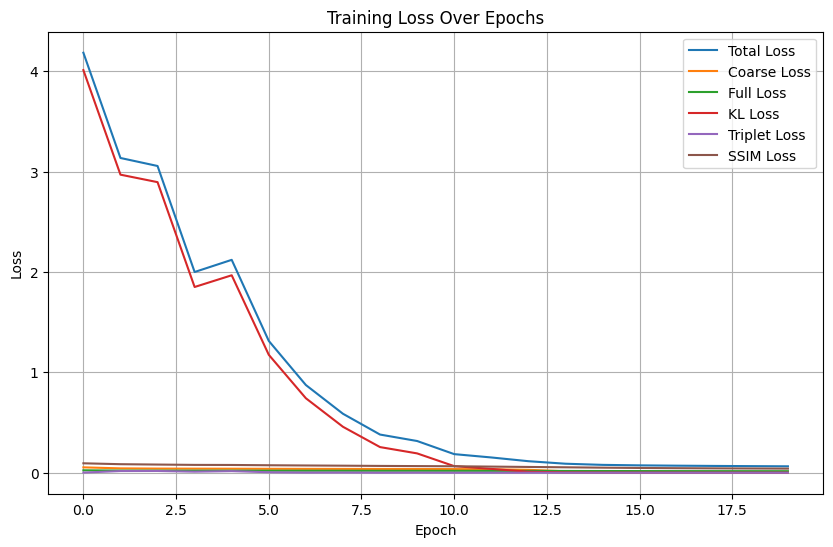

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history_tri_vae['loss'], label='Total Loss')
plt.plot(history_tri_vae['l1_loss_coarse'], label='Coarse Loss')
plt.plot(history_tri_vae['l1_loss_full'], label='Full Loss')
plt.plot(history_tri_vae['kl_loss'], label='KL Loss')
plt.plot(history_tri_vae['triplet_loss'], label='Triplet Loss')
plt.plot(history_tri_vae['ssim_loss'], label='SSIM Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

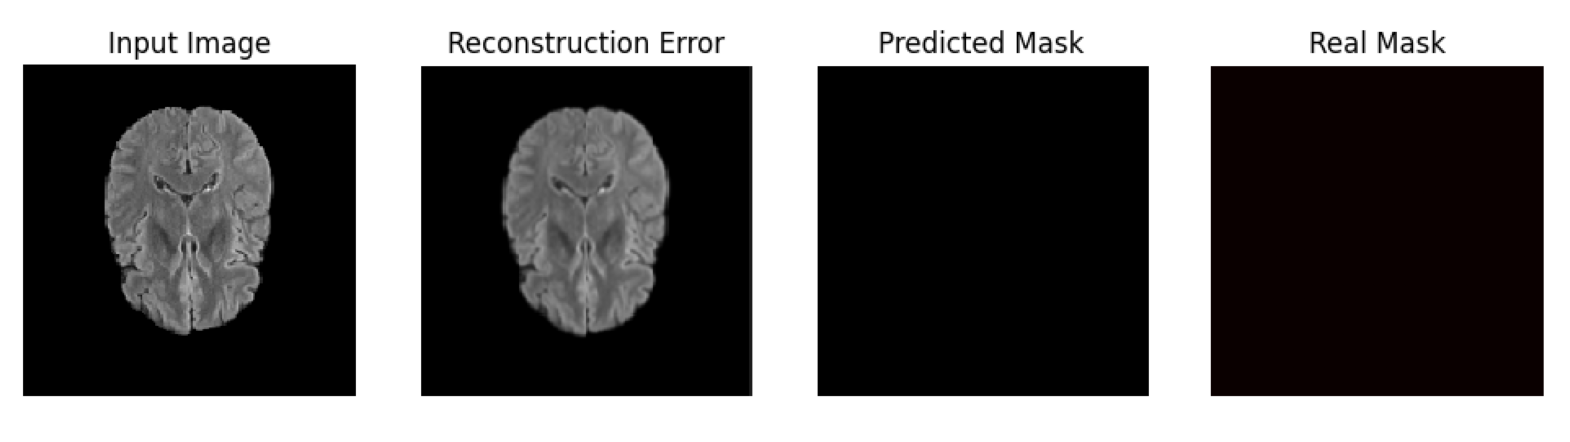

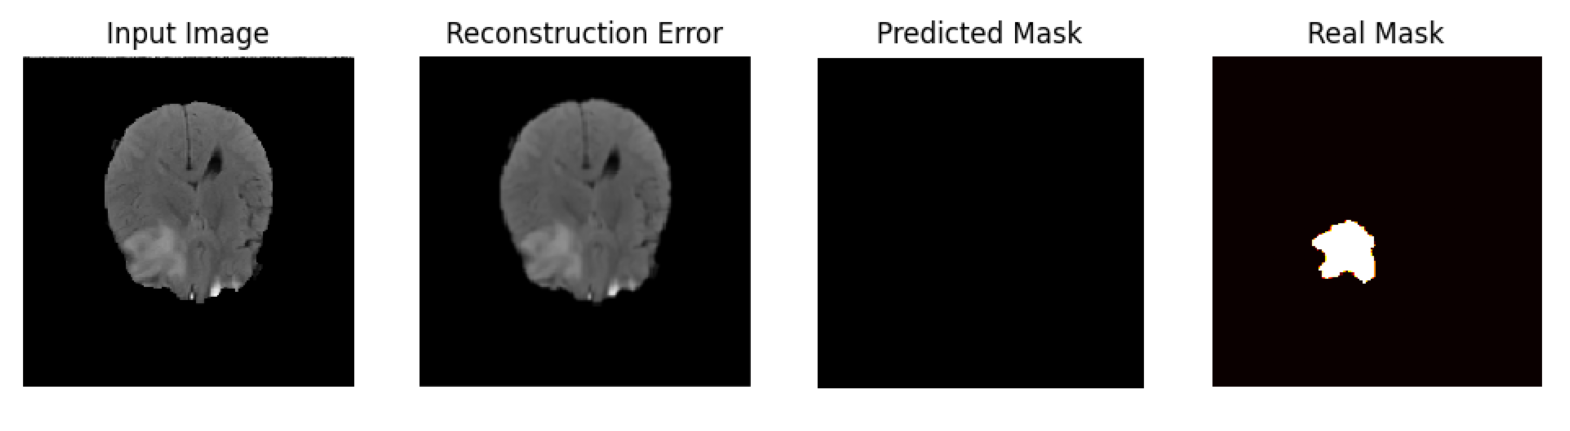

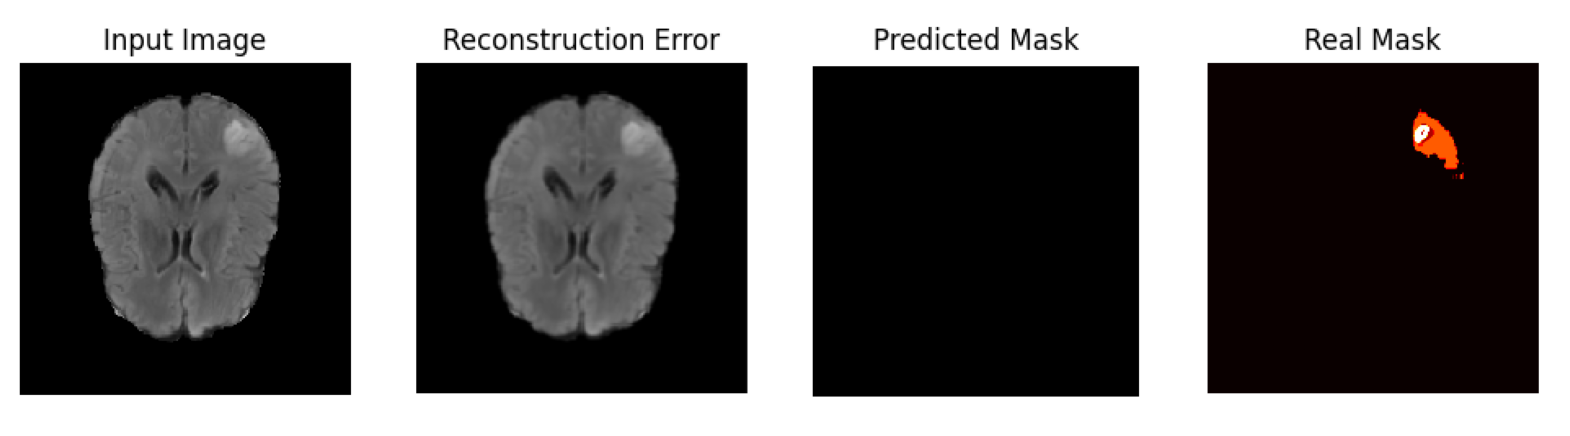

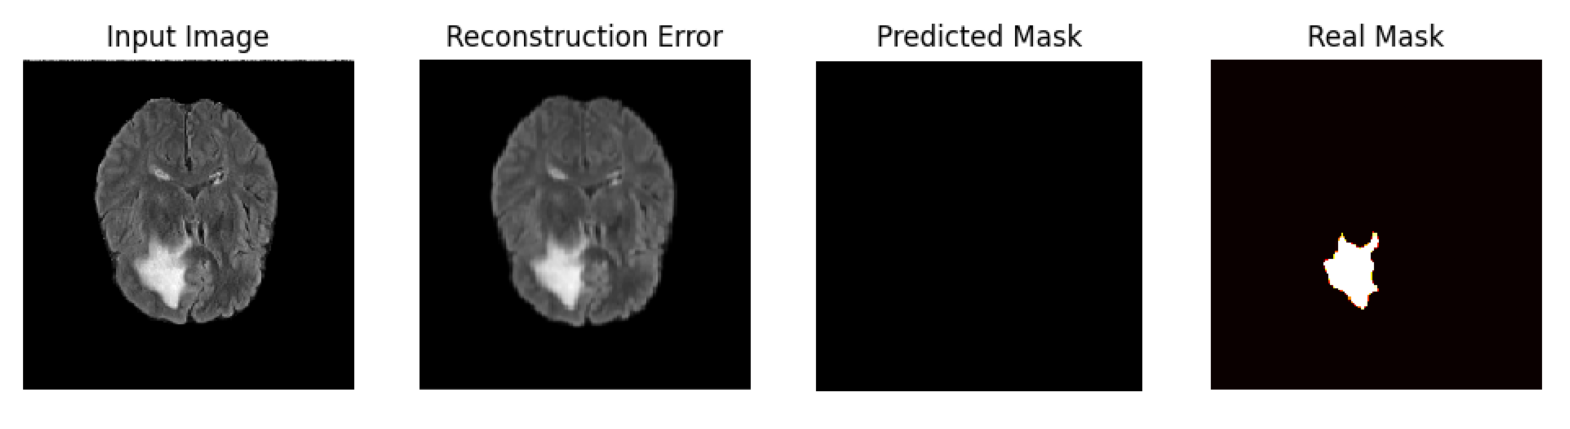

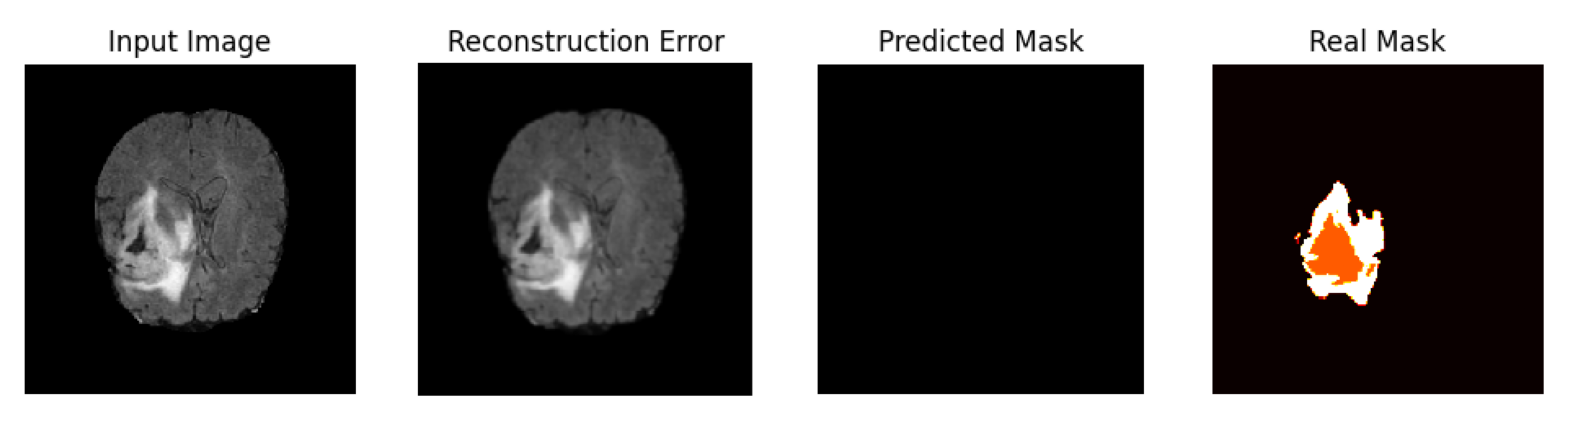

In [13]:
def load_brats_data(data_path, num_patients=100):
    image_slices = []
    mask_slices = []
    patient_dirs = sorted(os.listdir(data_path))[:num_patients]

    for patient_dir in patient_dirs:
        patient_path = os.path.join(data_path, patient_dir)

        image_path = os.path.join(patient_path, "t1ce.nii")
        image_data = nib.load(image_path).get_fdata()

        mask_path = os.path.join(patient_path, "seg.nii")
        mask_data = nib.load(mask_path).get_fdata()

        for slice_idx in range(image_data.shape[2]):
            image_slice = image_data[:, :, slice_idx]
            mask_slice = mask_data[:, :, slice_idx]

            if np.max(mask_slice) > 0:
                image_slices.append(image_slice)
                mask_slices.append(mask_slice)

    return np.array(image_slices), np.array(mask_slices)

images, masks = load_brats_data(brats_data_path)
processed_images = np.array([preprocess_image(img, target_size=(256, 256)) for img in images])
processed_masks = np.array([tf.image.resize(mask[..., np.newaxis], (256, 256)).numpy() for mask in masks])

def calculate_anomalies(images, masks, model, threshold=0.1):
    anomalies = []
    dice_scores = []

    for img, mask in zip(images, masks):
        img_input = img[np.newaxis, ..., np.newaxis]
        _, recon = model.predict({"anchor": img_input, "positive": img_input, "negative": img_input})

        error_map = np.abs(recon[0, ..., 0] - img[..., 0])
        predicted_mask = (error_map > threshold).astype(np.float32)

        dice = 2 * np.sum(predicted_mask * mask) / (np.sum(predicted_mask) + np.sum(mask) + 1e-8)
        dice_scores.append(dice)

        anomalies.append({
            "input_image": img[..., 0],
            "error_map": error_map,
            "predicted_mask": predicted_mask,
            "real_mask": mask[..., 0],
            "dice_score": dice
        })

    return anomalies, dice_scores

anomalies, dice_scores = calculate_anomalies(processed_images, processed_masks, loaded_model, threshold=0.1)

def plot_anomaly_results(anomalies, num_samples=5):
    for i, result in enumerate(anomalies[:num_samples]):
        plt.figure(figsize=(12, 8))

        plt.subplot(1, 4, 1)
        plt.title("Input Image")
        plt.imshow(result["input_image"], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.title("Reconstruction Error")
        plt.imshow(result["error_map"], cmap="hot")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.title("Predicted Mask")
        plt.imshow(result["predicted_mask"], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.title("Real Mask")
        plt.imshow(result["real_mask"], cmap="gray")
        plt.axis("off")

        plt.show()

plot_anomaly_results(anomalies, num_samples=5)

In [ ]:
import numpy as np
from scipy.ndimage import median_filter
from skimage.measure import label
from noise import snoise3

def generate_synthetic_data(shape):
    return np.random.rand(*shape) > 0.5

def apply_tri_vae(slice_2d):
    return slice_2d

def process_slices_to_volume(data_3d):
    slices = []
    for i in range(data_3d.shape[0]):
        processed_slice = apply_tri_vae(data_3d[i])
        slices.append(processed_slice)
    return np.stack(slices, axis=0)

def apply_3d_median_filter(volume):
    return median_filter(volume, size=3)

def remove_small_components(volume, size_threshold=50):
    labeled_volume, num_features = label(volume)
    component_sizes = np.bincount(labeled_volume.ravel())
    remove_mask = component_sizes < size_threshold
    remove_mask[0] = False
    filtered_volume = np.isin(labeled_volume, np.where(~remove_mask)[0])
    return filtered_volume

def dice_coefficient(true_volume, predicted_volume):
    intersection = np.logical_and(true_volume, predicted_volume).sum()
    return 2.0 * intersection / (true_volume.sum() + predicted_volume.sum())

def apply_simplex_noise(shape, scale=10.0):
    noise_volume = np.zeros(shape)
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                noise_volume[x, y, z] = snoise3(x / scale, y / scale, z / scale)
    return noise_volume

data_shape = (256, 256, 64)
true_volume = generate_synthetic_data(data_shape)
predicted_volume = process_slices_to_volume(true_volume)
filtered_volume = apply_3d_median_filter(predicted_volume)
cleaned_volume = remove_small_components(filtered_volume)
coarse_dice = dice_coefficient(true_volume, cleaned_volume)
simplex_noise = apply_simplex_noise(data_shape)
noisy_volume = np.logical_or(cleaned_volume, simplex_noise > 0.5)
simplex_cleaned_volume = remove_small_components(noisy_volume)
simplex_dice = dice_coefficient(true_volume, simplex_cleaned_volume)
print("Dice Score with Coarse Noise:", coarse_dice)
print("Dice Score with Simplex Noise:", simplex_dice)
results = {
    "Method": ["Coarse Noise", "Simplex Noise"],
    "Dice Score": [coarse_dice, simplex_dice]
}